##Installation and Import of Dependencies

In [1]:
!curl "https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py" -o pytorch-xla-env-setup.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6028  100  6028    0     0  29849      0 --:--:-- --:--:-- --:--:-- 29990


In [ ]:
#!python "/content/pytorch-xla-env-setup.py"

In [3]:
!pip install -q kaggle
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [63]:
from google.colab import files
import zipfile
from zipfile import ZipFile
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
import gc
import time
import random
from datetime import datetime
from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics


#The Libraries below use PyTorch XLA multiprocessing dependencies... will be useful in the chance TPUs are used
"""import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl"""

'import torch_xla\nimport torch_xla.core.xla_model as xm\nimport torch_xla.distributed.xla_multiprocessing as xmp\nimport torch_xla.distributed.parallel_loader as pl'

In [5]:
plt.style.use("dark_background")

##Data Loading

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucihere","key":"1c73be72364cc767c5cd7a18b19d4418"}'}

In [7]:
!mkdir ~/.kaggle

In [8]:
!cp kaggle.json ~/.kaggle/

In [9]:
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.75G/5.76G [01:04<00:00, 41.2MB/s]
100% 5.76G/5.76G [01:04<00:00, 95.2MB/s]


In [11]:
def zipextract(filepath,mode="r",remove=False,outpath = None):
  """
  Extracts contents of a .zip file into an output directory

  Input Parameters:
    filepath(str) = The filepath of the .zip file
    mode(str) = 'r' for read, 'w' for write
    remove(bool) = Whether the .zip file should remain or should be removed from current working directory
    outpath(str) = Output directory into which extracted files are sent to, after extraction

  Returns:
    None
  """

  with zipfile.ZipFile(filepath,mode) as datazip:
    datazip.extractall(path = outpath)
  if remove==True:
    cmd = "rm"
    os.system(cmd + " " + filepath)

In [12]:
def json_to_dict(filepath, remove=False):
  """
  Input Parameters:
    filepath(str) = The filepath of the .json file
    remove(bool) = Whether the .json file should remain or should be removed from current working directory

  Returns:
    Python dictionary converted from .json file
  """
  with open(filepath) as jsonfil:
    diction = json.load(jsonfil)
  if remove==True:
    cmd = "rm"
    os.system(cmd + " " + filepath)
  return diction

In [13]:
zipextract("/content/cassava-leaf-disease-classification.zip",remove=True)

In [14]:
classdict = json_to_dict("/content/label_num_to_disease_map.json")

In [15]:
!touch "/content/model_path.pth"

In [16]:
DATA_PATH = "/content/train.csv"
TRAIN_PATH = "/content/train_images"
TEST_PATH = "/content/test_images"
MODEL_PATH = "/content/model_path.pth"

##Preliminary EDA

In [17]:
data_csv = pd.read_csv("/content/train.csv")

In [18]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [19]:
data_csv.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [20]:
data_csv.count()

image_id    21397
label       21397
dtype: int64

In [21]:
data_csv['label'].unique()

array([0, 3, 1, 2, 4])

In [22]:
classdict

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

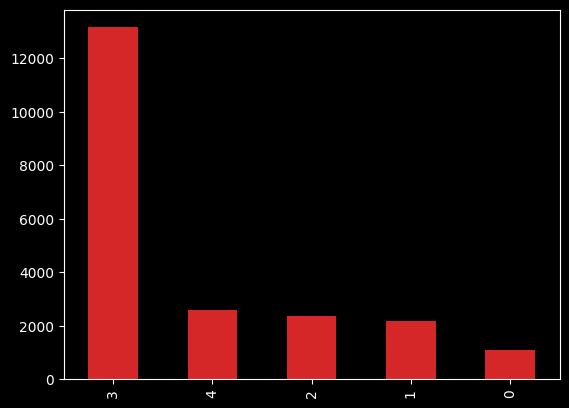

In [23]:
data_csv.label.value_counts().plot(kind="bar",color="tab:red")
plt.show()

##Dataset Wrangling

###PyTorch `torch.utils.data.Dataset` for Dataset usage in PyTorch-based models

In [24]:
class CassavaDataset(torch.utils.data.Dataset):
    """
    A class to represent the Cassava Leaf Disease Image Dataset
    ...

    Attributes
    ----------
    df_data : NumPy array
      Data obtained from the label DataFrame
    data_path : str
      Filepath of the image directory
    mode : str
        Whether it is a training dataset or a testing dataset
    transforms: transforms.Compose object
        Image Augmentation Transforms that will be applied on the dataset

    Methods
    -------
    __len__():
      Returns the number of images in dataset

    __getitem__(index):
      Returns image requested as Image object

    """

    def __init__(self, df, data_path=DATA_PATH, transforms=None, mode="train"):
      try:
          self.df_data = df.values
          self.data_path = data_path
          self.mode = mode
          self.data_dir = "train_images" if mode == "train" else "test_images"
      except AttributeError:
        return "Attribute Error.. Check Attributes properly"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        Image.open(img_path).convert("RGB")

In [25]:
train_df, valid_df = model_selection.train_test_split(
    data_csv, test_size=0.1, random_state=42, stratify=data_csv.label.values
)

In [26]:
IMG_SIZE = 224
BATCH_SIZE = 16
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 10

###Data Augmentation

In [27]:
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

###Model Class

We will be using the Vision Transformer 16 (Input size 224x224) since it is a state of the art model utilized for image classification tasks.. We will also tweak some of the hyperparameters in order to optimize validation accuracy.

In [28]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):
        super(ViTBase16, self).__init__()
        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        if pretrained:
            self.model.load_state_dict(torch.load(MODEL_PATH))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = self.forward(data)
            loss = criterion(output, target)
            loss.backward()
            accuracy = (output.argmax(dim=1) == target).float().mean()
            epoch_loss += loss
            epoch_accuracy += accuracy
            optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        valid_loss = 0.0
        valid_accuracy = 0.0
        self.model.eval()
        for data, target in valid_loader:
            with torch.no_grad():
                output = self.model(data)
                loss = criterion(output, target)
                accuracy = (output.argmax(dim=1) == target).float().mean()
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [29]:
model = ViTBase16(n_classes=5, pretrained=False)

In [30]:
def _run(lr):
    train_dataset = CassavaDataset(train_df, transforms=transforms_train)
    valid_dataset = CassavaDataset(valid_df, transforms=transforms_valid)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,drop_last=True)

    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=BATCH_SIZE,drop_last=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    torch.save(model.state_dict(), f'model_{datetime.now().strftime("%Y%m%d-%H%M")}.pth')

In [31]:
def _main_fn(lr,tensor_type="torch.FloatTensor"):
    torch.set_default_tensor_type(tensor_type)
    a = _run(lr)

In [32]:
_main_fn(lr=LR)

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


##Model Evaluation

In [59]:
def ViTBase16_eval(state_dict_path,eval=False):
  model = ViTBase16(n_classes=5,pretrained=False)
  model.load_state_dict(torch.load(state_dict_path))
  if eval==True:
    model.eval()

In [64]:
eval_model = ViTBase16_eval("/content/model_20231028-2032.pth",eval=True)
eval_model

Test image

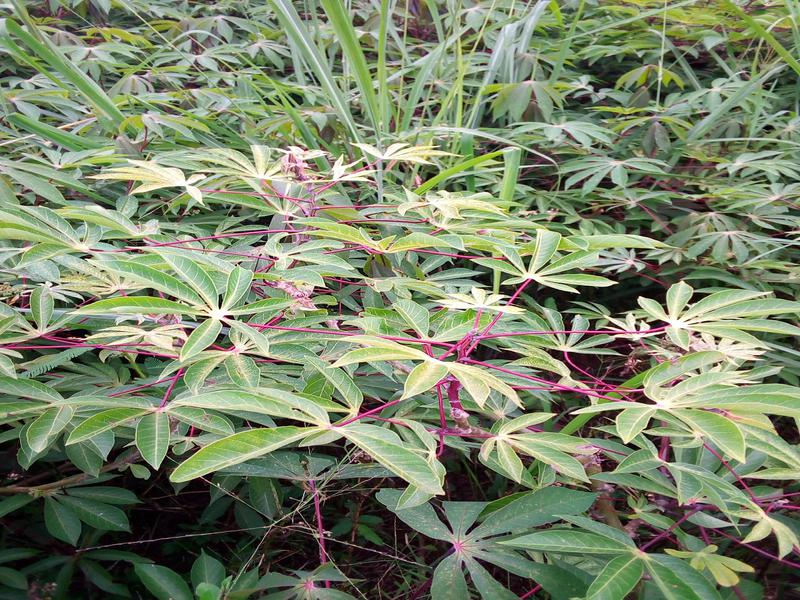

In [45]:
test_img = Image.open("/content/test_images/2216849948.jpg")
test_img